In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load the dataset
df = pd.read_excel(r"C:\Users\HP\Desktop\Extion Projects\Market Basket Analysis for Retailers\data\Online Retail.xlsx")  # Make sure the file is in the working directory
print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [10]:
# Check for missing values
print("Missing values per column:\n")
print(df.isnull().sum())


Missing values per column:

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [11]:
# Drop rows with missing CustomerID or Description
df.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Remove rows with negative Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add a TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

print("\nCleaned dataset shape:", df.shape)


Cleaned dataset shape: (397884, 9)


In [ ]:
# Filter only UK transactions
uk_data = df[df['Country'] == 'United Kingdom']

basket = uk_data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

# Convert quantities to 1 (purchased) or 0 (not purchased)
def encode_unit(x):
    if x <= 0:
        return 0
    else:
        return 1

basket_encoded = basket.map(encode_unit)

# Preview basket format
basket_encoded.head()


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Keep only frequent items (columns with >= 50 purchases)
item_freq = basket.sum(axis=0)
frequent_items = item_freq[item_freq >= 50].index
basket_reduced = basket[frequent_items]

# Keep only active customers (rows with >= 5 items)
basket_reduced = basket_reduced[basket_reduced.sum(axis=1) >= 5]

# Convert to binary format (1 for purchased, 0 for not purchased)
basket_encoded = basket_reduced.applymap(lambda x: 1 if x >= 1 else 0)

print("Reduced shape:", basket_encoded.shape)


C:\Users\HP\AppData\Local\Temp\ipykernel_14044\2215180037.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_encoded = basket_reduced.applymap(lambda x: 1 if x >= 1 else 0)


Reduced shape: (16222, 2872)


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Run Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket_encoded, min_support=0.02, use_colnames=True)

# Sort and display top frequent itemsets
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print("\nTop 10 Frequent Itemsets:")
print(frequent_itemsets.head(10))


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(



Top 10 Frequent Itemsets:
      support                              itemsets
192  0.116077  (WHITE HANGING HEART T-LIGHT HOLDER)
83   0.089138             (JUMBO BAG RED RETROSPOT)
156  0.086426            (REGENCY CAKESTAND 3 TIER)
11   0.080138       (ASSORTED COLOUR BIRD ORNAMENT)
128  0.079522                       (PARTY BUNTING)
105  0.069042             (LUNCH BAG RED RETROSPOT)
166  0.061706   (SET OF 3 CAKE TINS PANTRY DESIGN )
98   0.061336             (LUNCH BAG  BLACK SKULL.)
124  0.058254     (PAPER CHAIN KIT 50'S CHRISTMAS )
112  0.057761     (NATURAL SLATE HEART CHALKBOARD )


In [ ]:
# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Sort rules by highest lift
rules = rules.sort_values(by='lift', ascending=False)

print("\nTop 10 Association Rules:")
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)



Top 10 Association Rules:


,antecedents,consequents,support,confidence,lift
68,(GREEN REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",0.021021,0.559016,23.677190
65,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...",(GREEN REGENCY TEACUP AND SAUCER),0.021021,0.890339,23.677190
64,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",(PINK REGENCY TEACUP AND SAUCER),0.021021,0.716387,23.620371
69,(PINK REGENCY TEACUP AND SAUCER),"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...",0.021021,0.693089,23.620371
28,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.024843,0.660656,21.782840
29,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.024843,0.819106,21.782840
67,(ROSES REGENCY TEACUP AND SAUCER ),"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",0.021021,0.503693,20.275196
66,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.021021,0.846154,20.275196
4,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.029343,0.703102,18.697901
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.029343,0.780328,18.697901


C:\Users\HP\AppData\Local\Temp\ipykernel_14044\2932247690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='support', y=top_items['itemsets'].astype(str), data=top_items, palette="viridis")


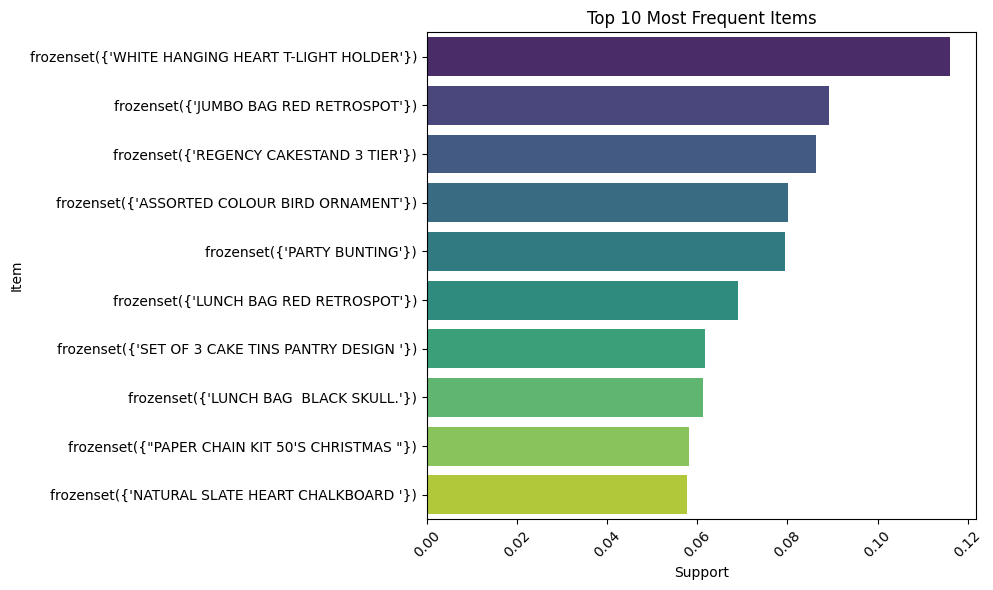

In [ ]:
# Add length column to identify single items
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

top_items = frequent_itemsets[frequent_itemsets['length'] == 1].nlargest(10, 'support')

plt.figure(figsize=(10, 6))
sns.barplot(x='support', y=top_items['itemsets'].astype(str), data=top_items, palette="viridis")
plt.title('Top 10 Most Frequent Items')
plt.xlabel('Support')
plt.ylabel('Item')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
